# Machine Transfer Learning

Dit notebook bevat de analyse en training waarbij een model wordt getraind op machine 1 en vervolgens wordt getest en gevalideerd op machine 2 en 3.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import itertools


# Zorg ervoor dat figuren groot genoeg zijn
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style('whitegrid')

# Directory setup
root_dir = os.path.dirname(os.getcwd())
export_dir = os.path.join(root_dir, 'export')
os.makedirs(export_dir, exist_ok=True)

df = pd.read_csv(os.path.join(export_dir, 'measurement_files_metadata.csv'))
display(df)


,machine,operation,class,measurements,channels,duration_sec,duration_min,file_size_mb,month_created,year_created,full_path
0,M01,OP00,good,268288,3,134.0,2.24,1.34,Aug,2019,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
1,M01,OP00,good,268288,3,134.0,2.24,1.37,Aug,2019,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
2,M01,OP00,good,267264,3,134.0,2.23,1.27,Feb,2021,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
3,M01,OP00,good,268288,3,134.0,2.24,1.34,Aug,2019,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
4,M01,OP00,good,268288,3,134.0,2.24,1.37,Aug,2019,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
...,...,...,...,...,...,...,...,...,...,...,...
1697,M02,OP14,good,67584,3,34.0,0.56,0.35,Aug,2021,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
1698,M02,OP14,good,66000,3,33.0,0.55,0.31,Feb,2019,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
1699,M02,OP14,good,68608,3,34.0,0.57,0.32,Feb,2020,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...
1700,M02,OP14,bad,53161,3,27.0,0.44,0.30,Feb,2019,/Users/koendebonth/Thesis/DSS_Thesis_CNC/data/...


## Verdeling van data over machines

Laten we eerst de verdeling van de data over de machines bekijken.

<Figure size 1500x1000 with 0 Axes>

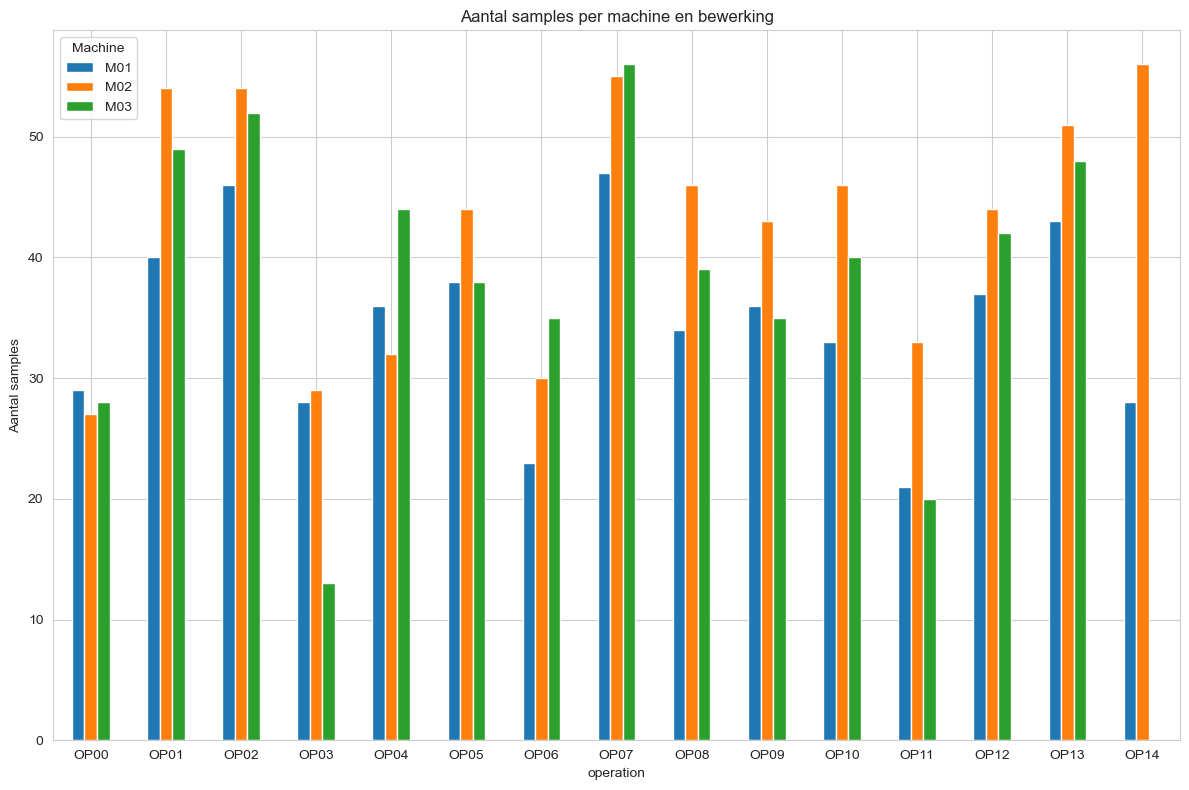

In [2]:
# Verdeling van samples over machines
machine_dist = pd.crosstab(
    [df['machine'], df['operation']], 
    df['class']
).assign(Total=lambda x: x.sum(axis=1)).sort_index()

# print("Verdeling van samples over machines:")
# display(machine_dist)

# Maak een visualisatie
plt.figure(figsize=(15, 10))
machine_dist.reset_index().pivot(index='operation', columns='machine', values='Total').plot(kind='bar')
plt.title('Aantal samples per machine en bewerking')
plt.ylabel('Aantal samples')
plt.xticks(rotation=0)
plt.legend(title='Machine')
plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'machine_distribution.png'), dpi=300)

# Signal analasys

In [3]:
import os
import sys
from pathlib import Path

# Get the current working directory
current_dir = os.getcwd()

# Set the root directory to the parent of the current directory
root_dir = Path(current_dir).parent

# Add the root directory to sys.path so Python can find the utils module
sys.path.append(str(root_dir))
print(f"Added {root_dir} to Python path")

os.chdir(Path(os.getcwd()).parent)

Added /Users/koendebonth/Thesis/DSS_Thesis_CNC to Python path


In [4]:
from utils.data_loader_utils import datafile_read

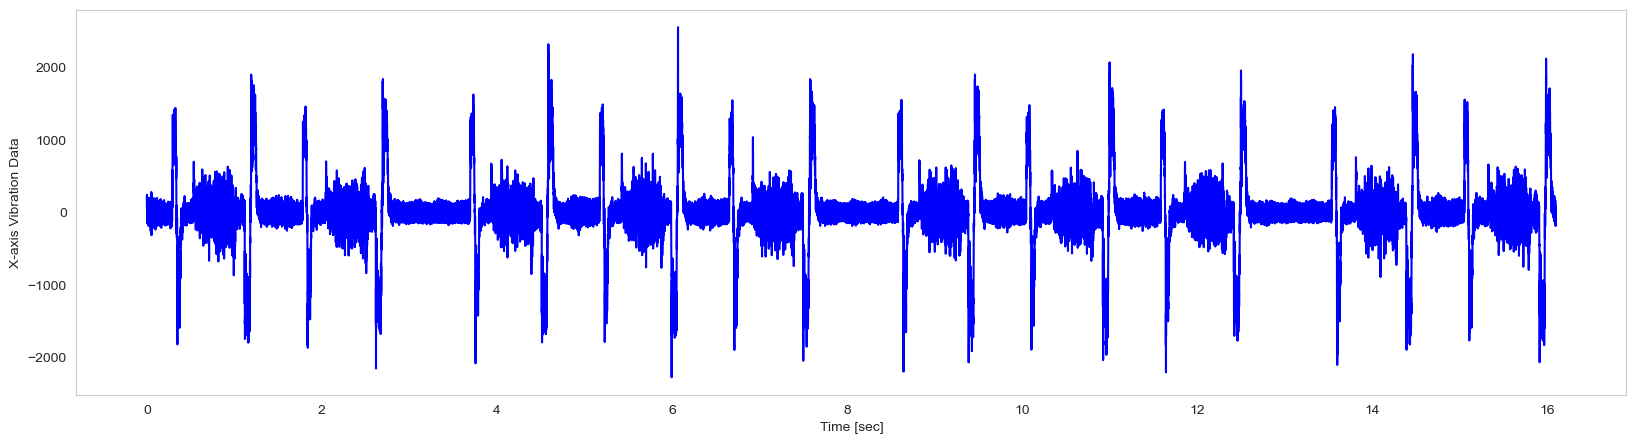

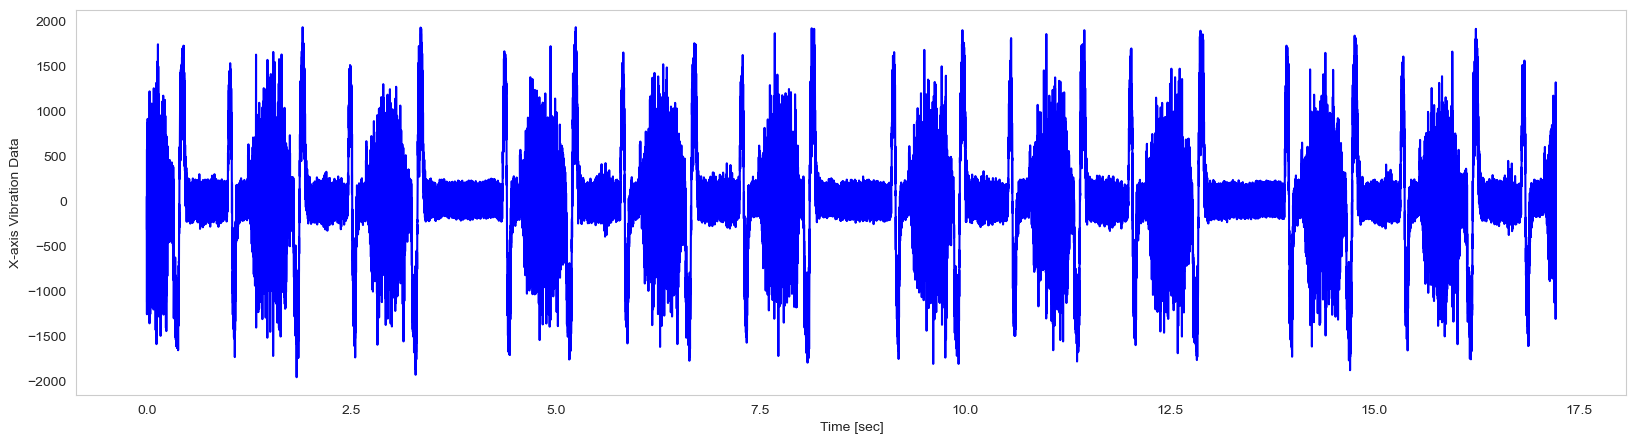

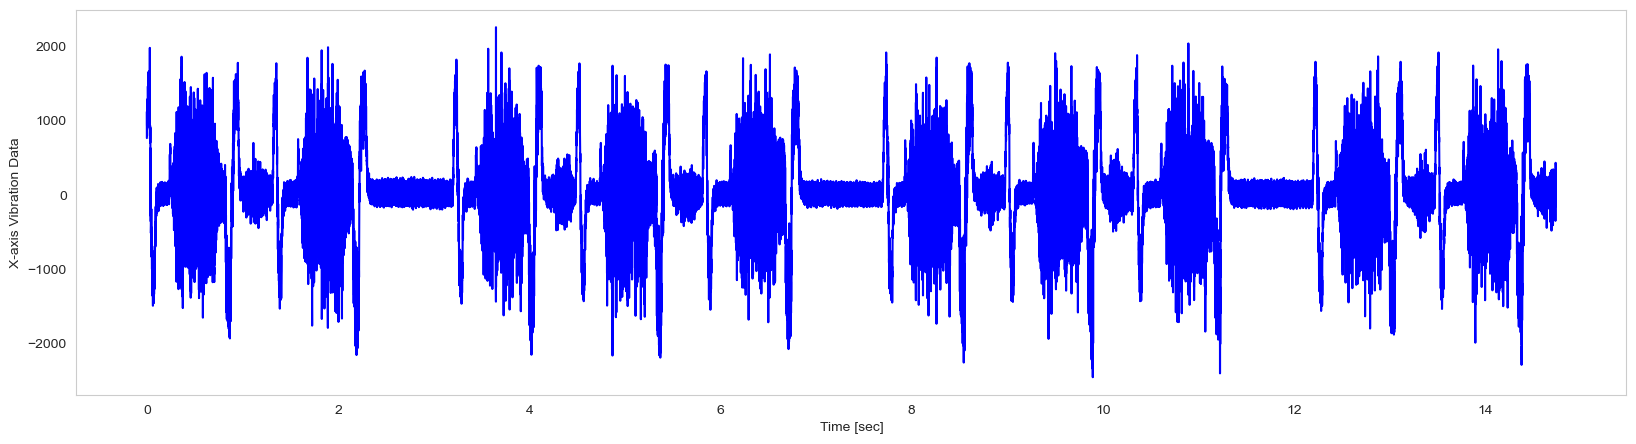

In [5]:
OP07_BAD_M01 = datafile_read('data/M01/OP07/bad/M01_Aug_2019_OP07_000.h5',axes=[0])
OP07_BAD_M02 = datafile_read('data/M02/OP07/bad/M02_Aug_2019_OP07_000.h5',axes=[0])
OP07_BAD_M03 = datafile_read('data/M03/OP07/bad/M03_Aug_2019_OP07_000.h5',axes=[0])

In [6]:
range(3)

range(0, 3)

In [7]:
import pywt

def wavelet_transform(signal, wavelet='coif8', maxlevel=3, mode='symmetric'):
    return pywt.WaveletPacket(data=signal, wavelet=wavelet, maxlevel=maxlevel, mode=mode)


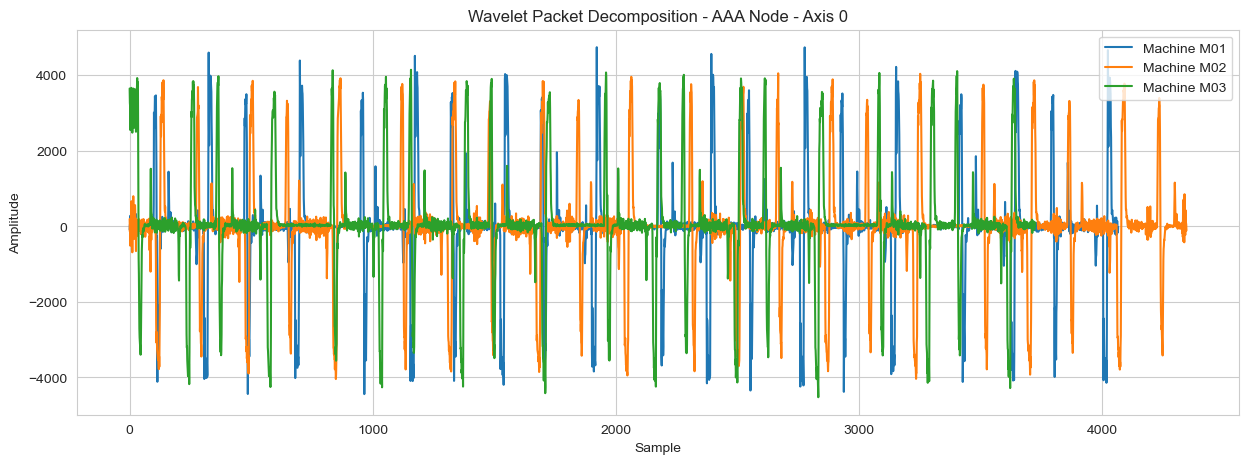

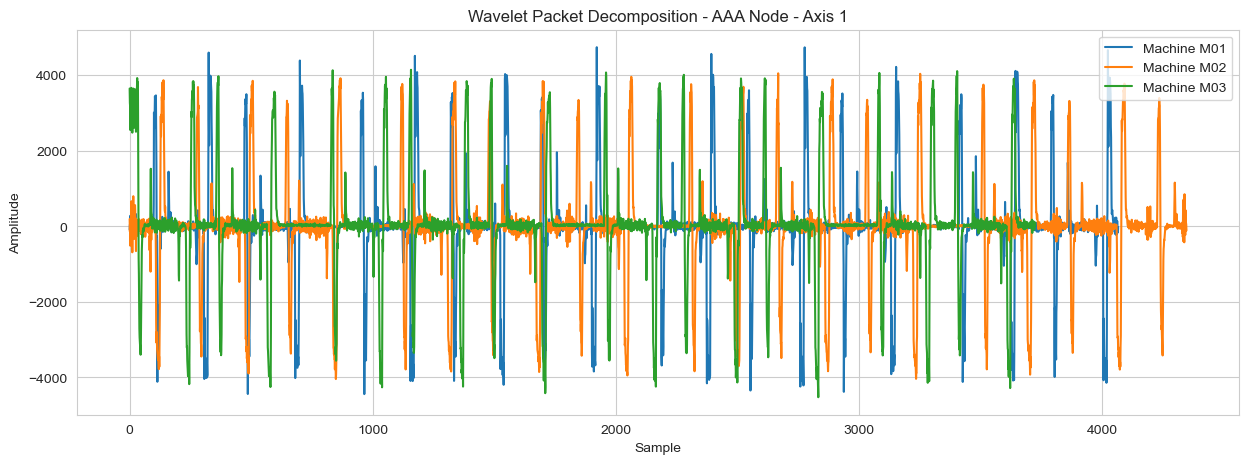

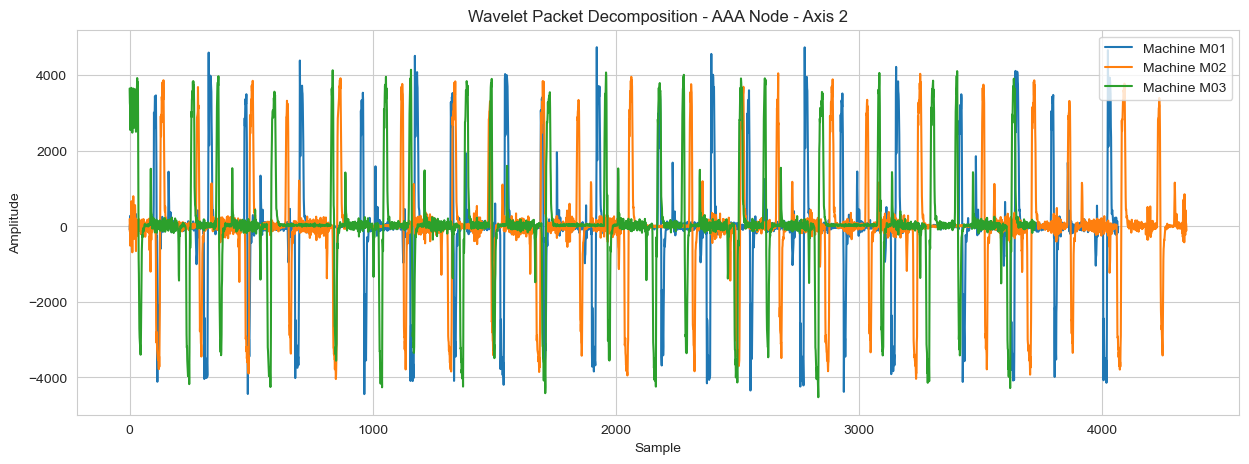

In [8]:
for j in range(3):
    plt.figure(figsize=(15,5))
    for i in range(3):
        machine_data = datafile_read(f'data/M0{i+1}/OP07/bad/M0{i+1}_Aug_2019_OP07_000.h5',axes=[j],plotting=False)
        wp_data = wavelet_transform(machine_data[:,0])
        plt.plot(wp_data['aaa'].data, label=f'Machine M0{i+1}')
    plt.title(f'Wavelet Packet Decomposition - AAA Node - Axis {j}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

In [12]:
OP07_BAD_M01_WP = wavelet_transform(OP07_BAD_M01[:,0])  
OP07_BAD_M02_WP = wavelet_transform(OP07_BAD_M02[:,0])
OP07_BAD_M03_WP = wavelet_transform(OP07_BAD_M03[:,0])

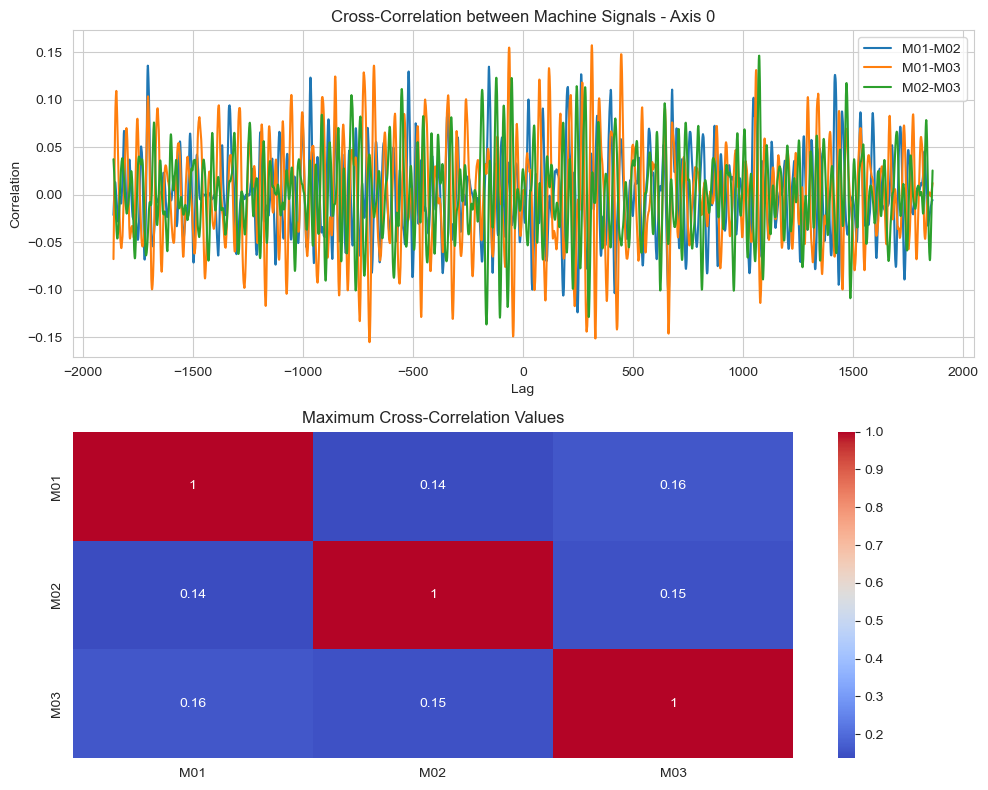

In [18]:
# Calculate cross-correlation between signals of the three machines
import numpy as np
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt

# Extract axis 0 data for each machine
m1_data = OP07_BAD_M01_WP['aaa'].data
m2_data = OP07_BAD_M02_WP['aaa'].data 
m3_data = OP07_BAD_M03_WP['aaa'].data

# Find minimum length across all signals
min_length = min(len(m1_data), len(m2_data), len(m3_data))

# Truncate signals to minimum length
m1_data = m1_data[:min_length]
m2_data = m2_data[:min_length] 
m3_data = m3_data[:min_length]

# Calculate cross-correlations
cross_corr_m1_m2 = signal.correlate(m1_data, m2_data, mode='same') / np.sqrt(signal.correlate(m1_data, m1_data, mode='same')[int(min_length/2)] * signal.correlate(m2_data, m2_data, mode='same')[int(min_length/2)])
cross_corr_m1_m3 = signal.correlate(m1_data, m3_data, mode='same') / np.sqrt(signal.correlate(m1_data, m1_data, mode='same')[int(min_length/2)] * signal.correlate(m3_data, m3_data, mode='same')[int(min_length/2)])
cross_corr_m2_m3 = signal.correlate(m2_data, m3_data, mode='same') / np.sqrt(signal.correlate(m2_data, m2_data, mode='same')[int(min_length/2)] * signal.correlate(m3_data, m3_data, mode='same')[int(min_length/2)])

# Create lag array for plotting
lags = np.arange(-min_length/2, min_length/2)

# Plot cross-correlations
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(lags, cross_corr_m1_m2, label='M01-M02')
plt.plot(lags, cross_corr_m1_m3, label='M01-M03')
plt.plot(lags, cross_corr_m2_m3, label='M02-M03')
plt.title('Cross-Correlation between Machine Signals - Axis 0')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

# Also create a matrix to show maximum cross-correlation values
max_corr_values = np.array([
    [1, np.max(cross_corr_m1_m2), np.max(cross_corr_m1_m3)],
    [np.max(cross_corr_m1_m2), 1, np.max(cross_corr_m2_m3)],
    [np.max(cross_corr_m1_m3), np.max(cross_corr_m2_m3), 1]
])

plt.subplot(2, 1, 2)
sns.heatmap(max_corr_values, annot=True, cmap='coolwarm', 
            xticklabels=['M01', 'M02', 'M03'],
            yticklabels=['M01', 'M02', 'M03'])
plt.title('Maximum Cross-Correlation Values')
plt.tight_layout()